# Exploring SWOT L1 Interferometric Heights

This notebook demonstrates the derivation of interferometric heights from SWOT L1B
high-resolution products using a transparent, physics-based processing chain.

The processing is implemented in a class where each physical step
(SLC loading, geometry, interferogram formation, multilooking, inversion, geolocation)
is exposed and callable independently.

This notebook is intended for being share amoing swot users and advance in open source HR tools.


In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cm

sys.path.append("..")

from src.Intf_processor import SWOTL1InterferogramProcessor

In [2]:
#set the location of the L1B file
fn = "../data/SWOT_L1B_HR_SLC_010_384_015L_20240207T164605_20240207T164612_PIC0_01.nc"

### Processing init
No processing is executed yet.
The processor is initialized with configuration parameters only.


In [3]:
#set the location of the L1B file
fn = "../data/SWOT_L1B_HR_SLC_010_384_015L_20240207T164605_20240207T164612_PIC0_01.nc"

p = SWOTL1InterferogramProcessor(
    fn,
    window=(32, 1), #multilooking window
    swath_side="L", #swath side 
    golstein=True, #golstein filter flag
    alpha=0.5, #goldstein alpha
    block=(32, 12), #golstein block
    gamma_thresh=0.5, #trehshol to filter based on coherence
)


In [4]:

p._read_l1()

print("SLC shape after nadir cut:", p.S1.shape)
print("Number of azimuth lines:", p.Ls)
print("Number of range pixels :", p.Ps)



SLC shape after nadir cut: (13502, 3636)
Number of azimuth lines: 13502
Number of range pixels : 3636


At this stage:
- SLCs are loaded and converted to complex form
- The nadir region is "detected" and cropped out. very much hardcoded
- GRDEM heights are resampled to the SLC grid
- Slant range geometry is established

We can take a look ath the raw, unfiltered radar intensities.
They serve as a baseline quality check and illustrate
polarization-dependent (VV HH) backscatter differences. 


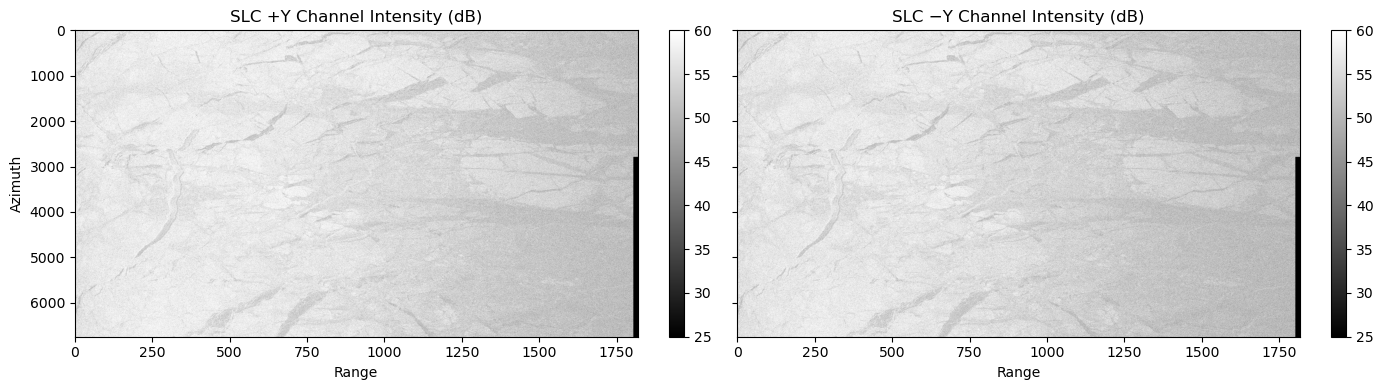

In [5]:

ds = 2  # undersampling factor

S1_int = 10 * np.log10(np.abs(p.S1[::ds, ::ds])**2 + 1e-12)
S2_int = 10 * np.log10(np.abs(p.S2[::ds, ::ds])**2 + 1e-12)

fig, axs = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

im1 = axs[0].imshow(
    S1_int,
    aspect="auto",
    cmap="gray",
    vmin=25,
    vmax=60,
)
axs[0].set_title("SLC +Y Channel Intensity (dB)")
axs[0].set_xlabel("Range")
axs[0].set_ylabel("Azimuth")
plt.colorbar(im1, ax=axs[0], fraction=0.046)

im2 = axs[1].imshow(
    S2_int,
    aspect="auto",
    cmap="gray",
    vmin=25,
    vmax=60,

)
axs[1].set_title("SLC −Y Channel Intensity (dB)")
axs[1].set_xlabel("Range")
plt.colorbar(im2, ax=axs[1], fraction=0.046)

plt.tight_layout()
plt.show()


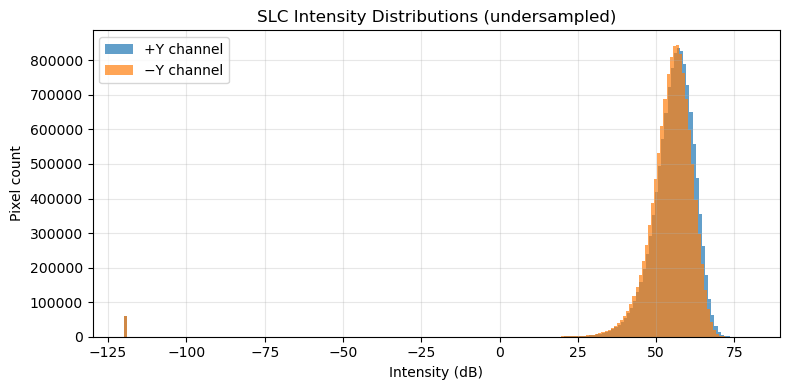

In [6]:
S1_flat = S1_int[np.isfinite(S1_int)]
S2_flat = S2_int[np.isfinite(S2_int)]

plt.figure(figsize=(8,4))
plt.hist(
    S1_flat,
    bins=200,
    alpha=0.7,
    label="+Y channel",
)
plt.hist(
    S2_flat,
    bins=200,
    alpha=0.7,
    label="−Y channel",
)

plt.xlabel("Intensity (dB)")
plt.ylabel("Pixel count")
plt.title("SLC Intensity Distributions (undersampled)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


The interferometric **height scaling factor S** maps phase variations
(in radians) into height variations (in meters):

$$
S = \frac{\lambda R \sin(\theta_{\text{look}})}{2\pi B_\perp}
$$

where:

- $\lambda$ is the radar wavelength,
- $R$ is the slant range,
- $\theta_{\text{look}}$ is the radar look angle,
- $B_\perp$ is the perpendicular baseline component.

The interferometric height is then obtained as:

$$
h = h_0 + S \,\phi
$$

where:

- $h_0$ is the reference DEM height,
- $\phi$ is the interferometric phase (radians).

Regions with large values of $S$ are more sensitive to phase noise,
and therefore exhibit increased height uncertainty.


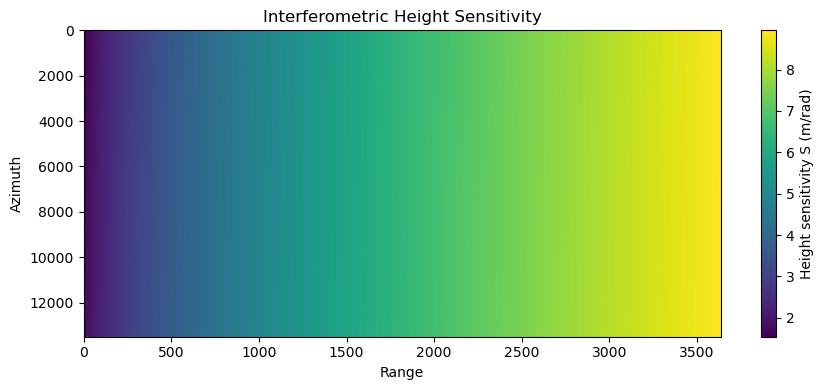

In [7]:
p._geometry()

plt.figure(figsize=(9, 4))
plt.imshow(p.S, aspect="auto")
plt.colorbar(label="Height sensitivity S (m/rad)")
plt.xlabel("Range")
plt.ylabel("Azimuth")
plt.title("Interferometric Height Sensitivity")
plt.tight_layout()
plt.show()

Large deterministic phase trends are removed prior to multilooking
to avoid biasing height estimates.


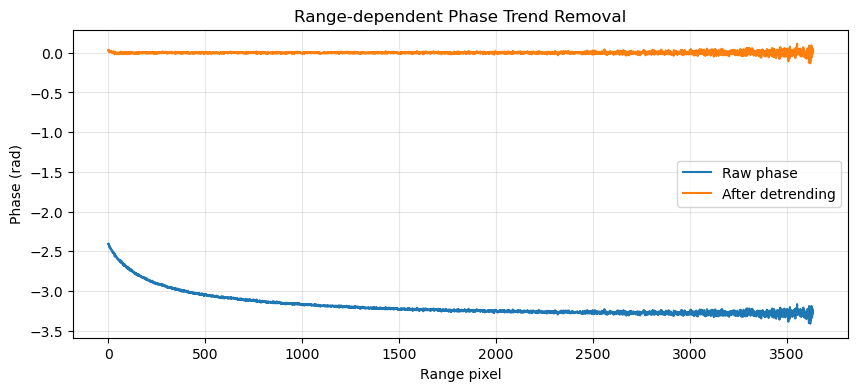

In [8]:
p._interferogram()

phi_raw = np.angle(np.mean(p.S1 * np.conj(p.S2), axis=0))
phi_det = np.angle(np.mean(p.S1_d * np.conj(p.S2_d), axis=0))

plt.figure(figsize=(10, 4))
plt.plot(np.unwrap(phi_raw), label="Raw phase")
plt.plot(np.unwrap(phi_det), label="After detrending")
plt.legend()
plt.xlabel("Range pixel")
plt.ylabel("Phase (rad)")
plt.title("Range-dependent Phase Trend Removal")
plt.grid(alpha=0.3)
plt.show()


Multilooking reduces interferometric phase variance by averaging incoherent
contributions, leading to a narrower phase distribution and improved phase
stability. High coherence values confirm reliable phase estimation and enhanced
height precision.
Optionally we can apply a goldstein filter. In thisc ase the filter flag was set to true when inizialiting the p class.

 In the plots bellow we can see that the multilooked one presents less noise and more information its seen (like ssha gradients).


In [9]:
p._multilook()



/home/framo4051/Documents/UIT/SWOT_L1B_SeaIce/notebooks/../src/Intf_processor.py:82: RuntimeWarning: invalid value encountered in sqrt
  gamma0 = np.abs(I0) / (np.sqrt(P1_0 * P2_0) + 1e-12)
/home/framo4051/Documents/UIT/SWOT_L1B_SeaIce/notebooks/../src/Intf_processor.py:86: RuntimeWarning: invalid value encountered in divide
  I_ml = (uniform_filter(I.real * w, size=window) +
/home/framo4051/Documents/UIT/SWOT_L1B_SeaIce/notebooks/../src/Intf_processor.py:92: RuntimeWarning: invalid value encountered in sqrt
  gamma_ml = np.abs(I_ml) / (np.sqrt(P1_ml * P2_ml) + 1e-12)


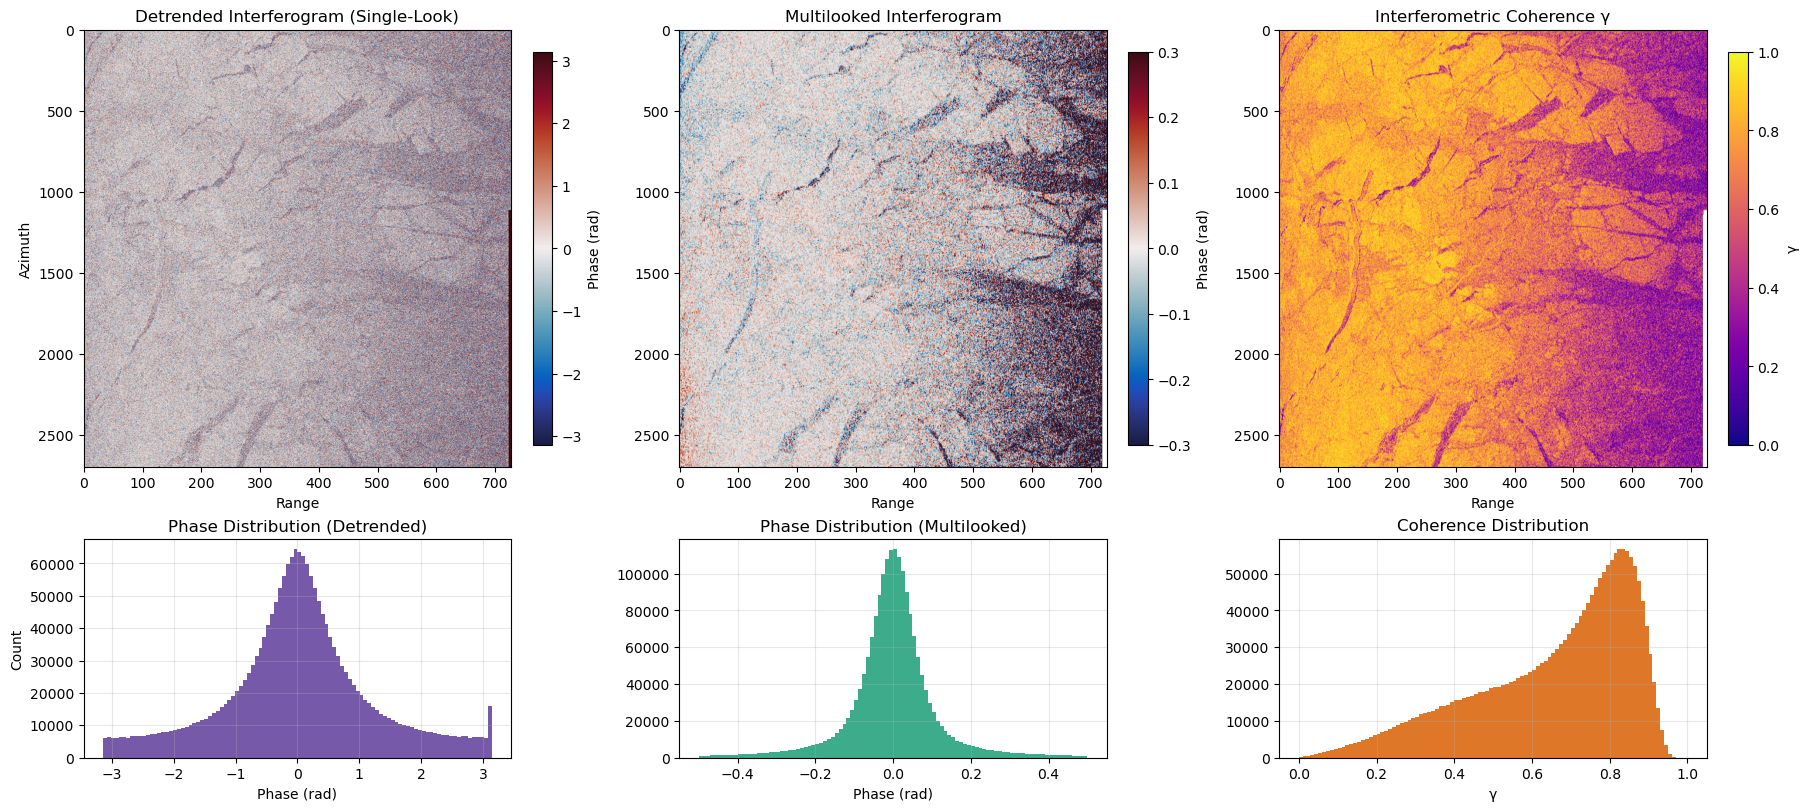

In [10]:
# -------------------------------------------------------
# Interferogram diagnostics:
# detrended single-look vs multilooked vs coherence
# + histograms
# -------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

# Detrended, single-look interferogram (before multilooking)
I_det = p.S1_d * np.conj(p.S2_d)
phi_det = np.angle(I_det)

# Multilooked products
phi_ml = p.phi_ml
gamma  = p.gamma_ml

# Undersample for visualization
ds = 5
phi_det_ds = phi_det[::ds, ::ds]
phi_ml_ds  = phi_ml[::ds, ::ds]
gamma_ds   = gamma[::ds, ::ds]

# Create figure
fig, axes = plt.subplots(
    2, 3,
    figsize=(18, 8),
    gridspec_kw={"height_ratios": [2, 1]},
    constrained_layout=True
)

# =======================================================
# TOP ROW — MAPS
# =======================================================

# --- Detrended interferogram ---
im0 = axes[0, 0].imshow(
    phi_det_ds,
    aspect="auto",
    cmap=cm.balance,
    vmin=-np.pi,
    vmax=np.pi,
)
axes[0, 0].set_title("Detrended Interferogram (Single-Look)")
axes[0, 0].set_xlabel("Range")
axes[0, 0].set_ylabel("Azimuth")
plt.colorbar(im0, ax=axes[0, 0], fraction=0.046, label="Phase (rad)")

# --- Multilooked interferogram ---
im1 = axes[0, 1].imshow(
    phi_ml_ds,
    aspect="auto",
    cmap=cm.balance,
    vmin=-0.3,
    vmax=0.3,
)
axes[0, 1].set_title("Multilooked Interferogram")
axes[0, 1].set_xlabel("Range")
plt.colorbar(im1, ax=axes[0, 1], fraction=0.046, label="Phase (rad)")

# --- Coherence ---
im2 = axes[0, 2].imshow(
    gamma_ds,
    aspect="auto",
    cmap="plasma",
    vmin=0,
    vmax=1,
)
axes[0, 2].set_title("Interferometric Coherence γ")
axes[0, 2].set_xlabel("Range")
plt.colorbar(im2, ax=axes[0, 2], fraction=0.046, label="γ")

# =======================================================
# BOTTOM ROW — HISTOGRAMS
# =======================================================

bins = 100

# Histogram: detrended interferogram
axes[1, 0].hist(
    phi_det_ds[np.isfinite(phi_det_ds)],
    bins=bins,
    range=(-np.pi, np.pi),
    color="#5e3c99",
    alpha=0.85,
)
axes[1, 0].set_title("Phase Distribution (Detrended)")
axes[1, 0].set_xlabel("Phase (rad)")
axes[1, 0].set_ylabel("Count")
axes[1, 0].grid(alpha=0.3)

# Histogram: multilooked interferogram
axes[1, 1].hist(
    phi_ml_ds[np.isfinite(phi_ml_ds)],
    bins=bins,
    range=(-0.5, 0.5),
    color="#1b9e77",
    alpha=0.85,
)
axes[1, 1].set_title("Phase Distribution (Multilooked)")
axes[1, 1].set_xlabel("Phase (rad)")
axes[1, 1].grid(alpha=0.3)

# Histogram: coherence
axes[1, 2].hist(
    gamma_ds[np.isfinite(gamma_ds)],
    bins=bins,
    range=(0, 1),
    color="#d95f02",
    alpha=0.85,
)
axes[1, 2].set_title("Coherence Distribution")
axes[1, 2].set_xlabel("γ")
axes[1, 2].grid(alpha=0.3)

plt.show()


Interferometric height is obtained as:

h = h₀ + S · φ

where h₀ is the reference DEM height.
Results are still noisy.

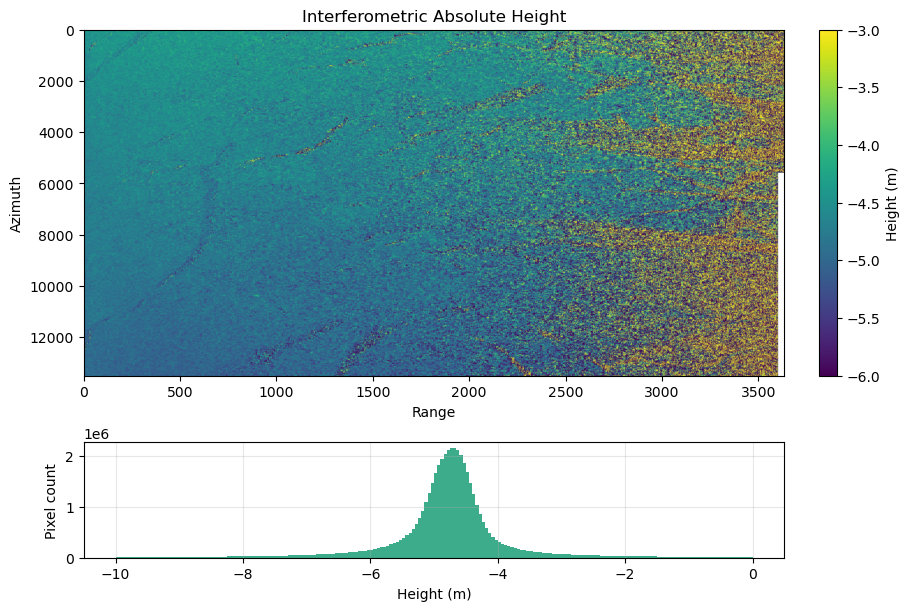

In [11]:
p._height()

import numpy as np
import matplotlib.pyplot as plt

# Data
h = p.h_abs

# Remove NaNs for histogram
h_valid = h[np.isfinite(h)]

fig, axes = plt.subplots(
    2, 1,
    figsize=(9, 6),
    gridspec_kw={"height_ratios": [3, 1]},
    constrained_layout=True,
)

# =======================
# TOP: Height map
# =======================
im = axes[0].imshow(
    h,
    aspect="auto",
    cmap="viridis",
    vmin=-6,
    vmax=-3,
)
axes[0].set_title("Interferometric Absolute Height")
axes[0].set_xlabel("Range")
axes[0].set_ylabel("Azimuth")
plt.colorbar(im, ax=axes[0], label="Height (m)")

# =======================
# BOTTOM: Histogram
# =======================
axes[1].hist(
    h_valid,
    bins=200,
    color="#1b9e77",
    alpha=0.85,
    range=(-10,0)
)

axes[1].set_xlabel("Height (m)")
axes[1].set_ylabel("Pixel count")
axes[1].grid(alpha=0.3)

plt.show()


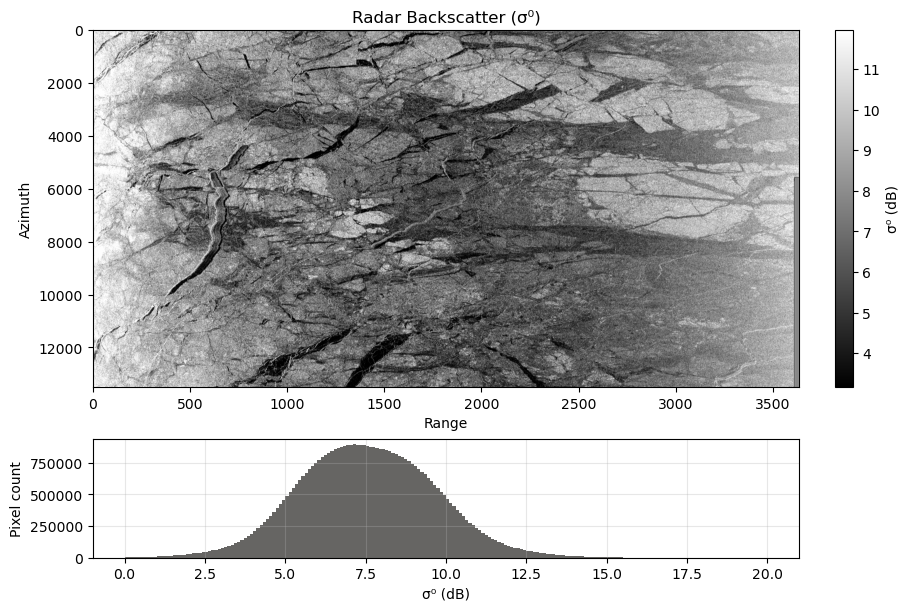

In [12]:
p._geolocate()
p._sigma0()

# Data
s0 = p.sigma0_db
s0_valid = s0[np.isfinite(s0)]

# Robust limits for display
vmin, vmax = np.nanpercentile(s0_valid, [2, 98])

fig, axes = plt.subplots(
    2, 1,
    figsize=(9, 6),
    gridspec_kw={"height_ratios": [3, 1]},
    constrained_layout=True,
)

# =======================
# TOP: Sigma0 map
# =======================
im = axes[0].imshow(
    s0,
    aspect="auto",
    cmap="gray",
    vmin=vmin,
    vmax=vmax,
)
axes[0].set_title("Radar Backscatter (σ⁰)")
axes[0].set_xlabel("Range")
axes[0].set_ylabel("Azimuth")
plt.colorbar(im, ax=axes[0], label="σ⁰ (dB)")

# =======================
# BOTTOM: Histogram
# =======================
axes[1].hist(
    s0_valid,
    bins=200,
    color="#4B4A48",
    alpha=0.85,
    range= (0,20)
)

axes[1].set_xlabel("σ⁰ (dB)")
axes[1].set_ylabel("Pixel count")
axes[1].grid(alpha=0.3)

plt.show()


Low-coherence pixels and extreme outliers can be further removed.
In this case we can used the prioly seet coherence treshold and filter by 99% percentile.


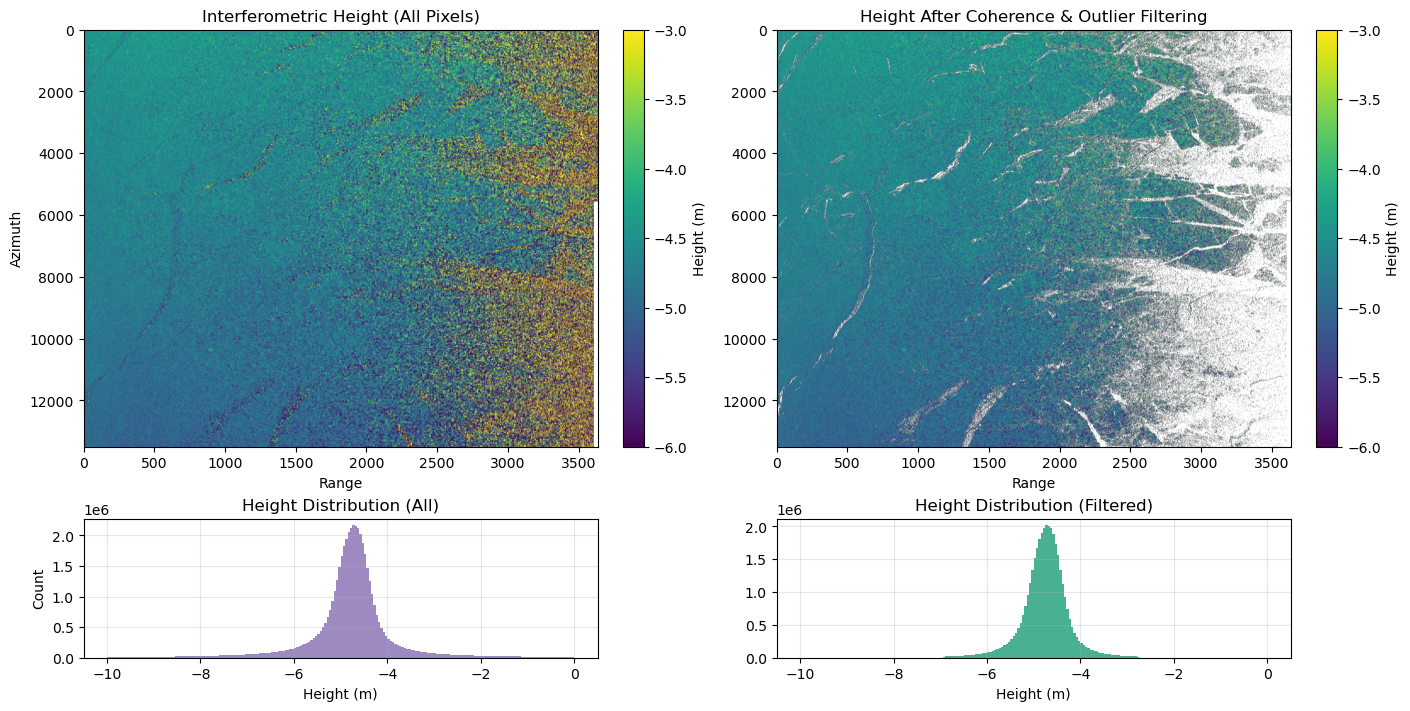

In [13]:
p._filter_height()



h_all = p.h_abs
h_flt = p.h_abs_filtered

h_all_v = h_all[np.isfinite(h_all)]
h_flt_v = h_flt[np.isfinite(h_flt)]

vmin, vmax = -6,-3

fig, axes = plt.subplots(
    2, 2,
    figsize=(14, 7),
    gridspec_kw={"height_ratios": [3, 1]},
    constrained_layout=True,
)

# =======================
# TOP ROW — MAPS
# =======================

# Unfiltered height
im0 = axes[0, 0].imshow(
    h_all,
    aspect="auto",
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
)
axes[0, 0].set_title("Interferometric Height (All Pixels)")
axes[0, 0].set_xlabel("Range")
axes[0, 0].set_ylabel("Azimuth")
plt.colorbar(im0, ax=axes[0, 0], label="Height (m)")

# Filtered height
im1 = axes[0, 1].imshow(
    h_flt,
    aspect="auto",
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
)
axes[0, 1].set_title("Height After Coherence & Outlier Filtering")
axes[0, 1].set_xlabel("Range")
plt.colorbar(im1, ax=axes[0, 1], label="Height (m)")

# =======================
# BOTTOM ROW — HISTOGRAMS
# =======================

bins = 200

# All heights
axes[1, 0].hist(
    h_all_v,
    bins=bins,
    color="#5e3c99",
    alpha=0.6,
    label="All",
    range=(-10,0)
)
axes[1, 0].set_title("Height Distribution (All)")
axes[1, 0].set_xlabel("Height (m)")
axes[1, 0].set_ylabel("Count")
axes[1, 0].grid(alpha=0.3)

# Filtered heights
axes[1, 1].hist(
    h_flt_v,
    bins=bins,
    color="#1b9e77",
    alpha=0.8,
    label="Filtered",
    range=(-10,0)
)
axes[1, 1].set_title("Height Distribution (Filtered)")
axes[1, 1].set_xlabel("Height (m)")
axes[1, 1].grid(alpha=0.3)

plt.show()


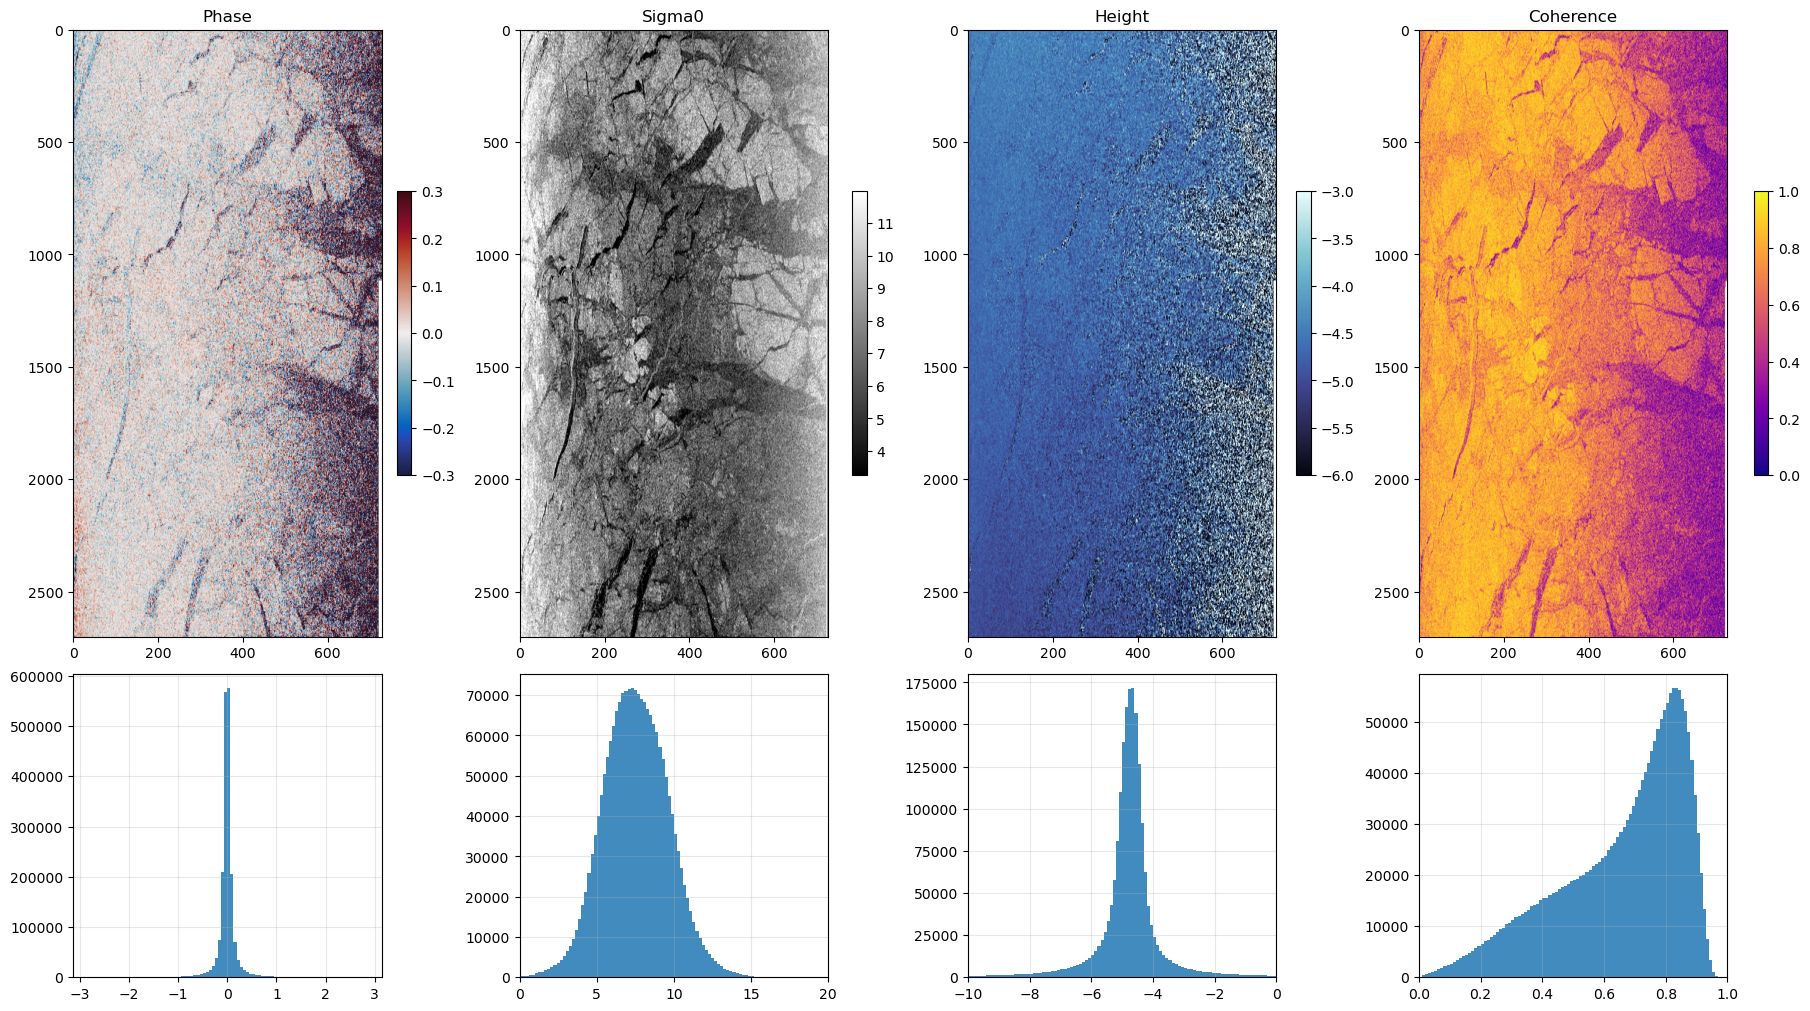

In [14]:
ds = 5
phi_ds   = p.phi_ml[::ds, ::ds]
sig0_ds  = p.sigma0_db[::ds, ::ds]
habs_ds  = p.h_abs[::ds, ::ds]
gamma_ds = p.gamma_ml[::ds, ::ds]

# ------------------------------------------------
# Define visualization and histogram ranges
# ------------------------------------------------
color_limits = {
    "Phase":     (-0.3, 0.3),
    "Sigma0":    np.nanpercentile(sig0_ds, [2, 98]),
    "Height":    (-6,-3),
    "Coherence": (0, 1),
}

hist_limits = {
    "Phase":     (-np.pi, np.pi),
    "Sigma0":    (0, 20),
    "Height":    (-10, 0),
    "Coherence": (0, 1),
}

products = [
    (phi_ds,   cm.balance, "Phase"),
    (sig0_ds,  "gray",     "Sigma0"),
    (habs_ds,  cm.ice,  "Height"),
    (gamma_ds, "plasma",   "Coherence"),
]

fig, axs = plt.subplots(
    2, 4,
    figsize=(18, 10),
    gridspec_kw={"height_ratios": [2, 1]},
    constrained_layout=True,
)

# =======================
# TOP ROW — MAPS
# =======================
for i, (data, cmap, title) in enumerate(products):

    vmin, vmax = color_limits[title]

    im = axs[0, i].imshow(
        data,
        aspect="auto",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
    )

    axs[0, i].set_title(title)
    plt.colorbar(im, ax=axs[0, i], fraction=0.046)

# =======================
# BOTTOM ROW — HISTOGRAMS
# =======================
for i, (data, _, title) in enumerate(products):

    xmin, xmax = hist_limits[title]

    axs[1, i].hist(
        data[np.isfinite(data)],
        bins=100,
        range=(xmin, xmax),
        alpha=0.85,
    )

    axs[1, i].set_xlim(xmin, xmax)
    axs[1, i].grid(alpha=0.3)

plt.show()
